# Biased data in BERT

In [1]:
from data_utils import *

In [2]:
import os
import json

def json2Dataframe(path):
    dataset = []
    with open(path, 'r') as f:
        json_data = json.load(f)

    for i, line in enumerate(json_data):
        tmpdict = {
        'premise': json_data[str(i)]['premise'],
        'hypothesis': json_data[str(i)]['hypothesis'],
        'gold_label': json_data[str(i)]['gold_label']
        }
        dataset.append(tmpdict)
    df = pd.DataFrame(dataset)
    return df

def generateBiasDataset(df_train, MAX_LENGTH=64, isTrain=True):
    df_train = rmvNeg(df_train)
    input_ids, labels = token2ids(df_train, MAX_LENGTH)
    attn_masks = createAttnMask(input_ids)
    input_ids = torch.tensor(input_ids)
    attn_masks = torch.tensor(attn_masks)
    labels = torch.tensor(labels)
    data = TensorDataset(input_ids, attn_masks, labels)
    if isTrain:
        sampler = RandomSampler(data)
    else:
        sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=32)
    return dataloader

# Note
### Here I used biased training dataset(remove word related to "female"), but used unbiased dataset for validation and test, you can check that the length of train_dataloader is different with training dataset in another notebook

In [3]:
df = json2Dataframe('./bias_dataset/snli_1.0_train.jsonl')
train_dataloader = generateBiasDataset(df)
val_dataloader = generateDataset(dataPath='./dataset/snli_1.0_dev.jsonl', isTrain=False)
print("length of train loader: {}".format(len(train_dataloader)))
print("length of val loader: {}".format(len(val_dataloader)))

length of train loader: 13197
length of val loader: 308


In [4]:
from transformers import AdamW, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
import torch
from train_epoch import evaluate
import torch.nn as nn
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from transformers import get_linear_schedule_with_warmup
from train_epoch import train, evaluate, bert_predict

epochs = 2
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses, val_losses, val_acc = train(model, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, evaluation=True, device=device, FINETUNE=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.581226   |     -      |     -     |   42.55  
   1    |   400   |   0.470333   |     -      |     -     |   35.18  
   1    |   600   |   0.447276   |     -      |     -     |   35.31  
   1    |   800   |   0.433761   |     -      |     -     |   35.32  
   1    |  1000   |   0.419696   |     -      |     -     |   35.45  
   1    |  1200   |   0.397304   |     -      |     -     |   35.43  
   1    |  1400   |   0.393932   |     -      |     -     |   35.35  
   1    |  1600   |   0.390886   |     -      |     -     |   35.38  
   1    |  1800   |   0.379350   |     -      |     -     |   35.37  
   1    |  2000   |   0.371469   |     -      |     -     |   35.35  
   1    |  2200   |   0.375487   |     -      |     -     |   35.35  
   1    |  2400   |   0.373932   |     -      |     -     |   35.36  


   2    |  9000   |   0.227745   |     -      |     -     |   35.38  
   2    |  9200   |   0.226175   |     -      |     -     |   35.39  
   2    |  9400   |   0.237898   |     -      |     -     |   35.41  
   2    |  9600   |   0.227972   |     -      |     -     |   35.39  
   2    |  9800   |   0.223607   |     -      |     -     |   35.36  
   2    |  10000  |   0.221107   |     -      |     -     |   35.38  
   2    |  10200  |   0.224030   |     -      |     -     |   35.36  
   2    |  10400  |   0.215053   |     -      |     -     |   35.38  
   2    |  10600  |   0.220768   |     -      |     -     |   35.36  
   2    |  10800  |   0.218026   |     -      |     -     |   35.37  
   2    |  11000  |   0.227475   |     -      |     -     |   35.37  
   2    |  11200  |   0.221499   |     -      |     -     |   35.38  
   2    |  11400  |   0.228994   |     -      |     -     |   35.38  
   2    |  11600  |   0.232926   |     -      |     -     |   35.39  
   2    |  11800  | 

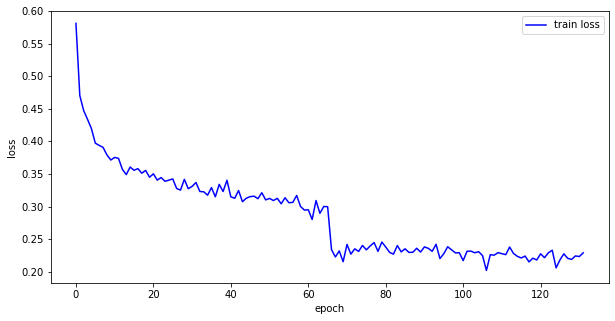

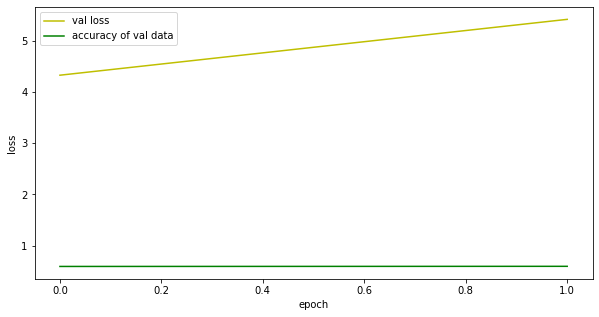

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss", c='b')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label="val loss", c='y')
plt.plot(val_acc, label="accuracy of val data", c='g')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [8]:
label = ['entailment', 'neutral', 'contradiction']

def bertPredict(model, b_input_ids, b_attn_mask, FINETUNE):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
        if FINETUNE:
            logits = logits["logits"]
    preds = torch.argmax(logits, dim=1).flatten()
    predictions = []
    for pred in preds.cpu().numpy():
        predictions.append(label[pred])
    return predictions


def evaluateRandomly(model, test_dataloader, n=1, FINETUNE=False):
    for i, sample in enumerate(test_dataloader):
        if i > n: break
            
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in sample)
        predict = bertPredict(model, b_input_ids, b_attn_mask, FINETUNE)
        b_labels = b_labels.cpu().numpy()
        for i, pred in enumerate(b_labels):
            print("label: {} --- predict: {}".format(label[b_labels[i]], predict[i]))

In [9]:
test_dataloader = generateDataset(dataPath='./dataset/snli_1.0_test.jsonl', isTrain=False)
test_loss, test_acc = evaluate(model, loss_fn, test_dataloader, device=device, FINETUNE=True)
print("Accuracy on test dataset: {}".format(test_acc))
evaluateRandomly(model, test_dataloader, FINETUNE=True)

Accuracy on test dataset: 59.46661237785016
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: entailment
label: neutral --- predict: neutral
label: entailment --- predict: neutral
label: contradiction --- predict: neutral
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: contradiction --- predict: entailment
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: neutral
label: entailment --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: entailment
label: contradiction --- predict: entailment
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: entailment
label: neutral --- predict: entailment
label: contradiction --- predict: entailment
label: entailment --- predict: entailment
label: neut